In [3]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

print(wv)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
KeyedVectors<vector_size=300, 3000000 keys>


In [4]:
from gensim.models import KeyedVectors

# Save the model to a binary file
wv.save_word2vec_format('word2vec_model.bin', binary=True)


In [5]:
# Load the model using memory-mapped files
import gensim
word2vec_model_path = "word2vec_model.bin"
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)


Task1


Task1
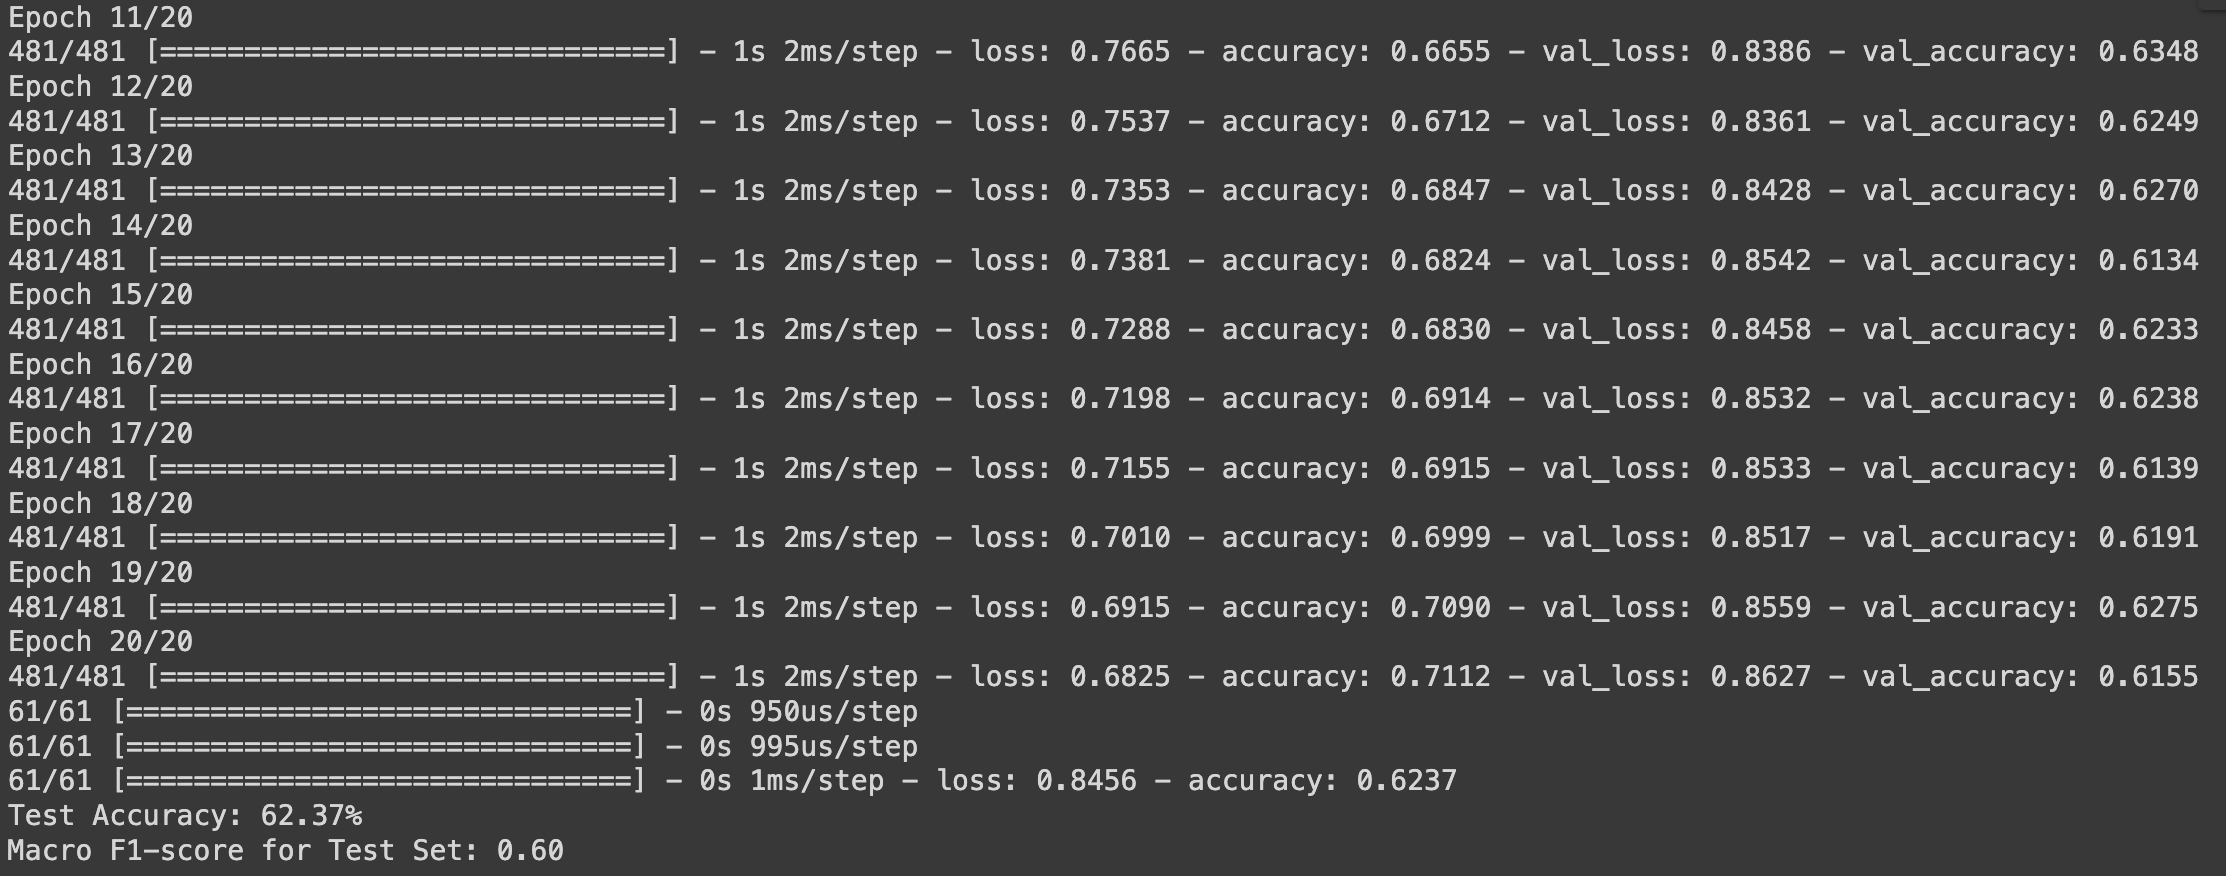

In [21]:
# Download and load the dataset
# Download and load the dataset from the provided URLs
# Ensure to cite the source of the dataset if applicable
import gensim
import gdown
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from keras.layers import Dropout


train_url = "https://drive.google.com/uc?export=download&id=1Pa-6DXYm_pfIte5KKAcKd-aECWzq5cPy"
valid_url = "https://drive.google.com/uc?export=download&id=1BDhkyqt9JmSLFpWKMFe7w7HAwTpfQfSf"
test_url = "https://drive.google.com/uc?export=download&id=1u4wx-OiwoKSXn8vSSGPGEpCDkiqKwDWd"

gdown.download(train_url, "NLP_ass_train.tsv", quiet=False)
gdown.download(valid_url, "NLP_ass_valid.tsv", quiet=False)
gdown.download(test_url, "NLP_ass_test.tsv", quiet=False)

# Load the data
train_data = pd.read_csv("NLP_ass_train.tsv", sep='\t', header=None)
valid_data = pd.read_csv("NLP_ass_valid.tsv", sep='\t', header=None)
test_data = pd.read_csv("NLP_ass_test.tsv", sep='\t', header=None)

# Preprocess the comments

# Preprocess the comments: Tokenization, lowercase conversion, and stopword removal
# Credits: Tokenization and stopwords removal inspired by NLTK library.

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

train_data[0] = train_data[0].apply(lambda x: preprocess_text(x))
valid_data[0] = valid_data[0].apply(lambda x: preprocess_text(x))
test_data[0] = test_data[0].apply(lambda x: preprocess_text(x))

# Encode labels
# Encode labels using LabelEncoder for model training
# Credits: Utilizing scikit-learn's LabelEncoder for label encoding.

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[1])
valid_labels = label_encoder.transform(valid_data[1])
test_labels = label_encoder.transform(test_data[1])

# Generate Word2Vec vectors for comments
# def get_average_word2vec(comment, model, num_features=300):
#     feature_vector = np.zeros((num_features,), dtype="float32")
#     num_words = 0
#     for word in comment:
#         if word in model.wv.vocab:
#             num_words += 1
#             feature_vector = np.add(feature_vector, model[word])
#     if num_words != 0:
#         feature_vector = np.divide(feature_vector, num_words)
#     return feature_vector

# def get_average_word2vec(comment, model, num_features=300):
#     feature_vector = np.zeros((num_features,), dtype="float32")
#     num_words = 0
#     for word in comment:
#         if word in model.vocab:  # Check if the word is in the vocabulary
#             num_words += 1
#             feature_vector = np.add(feature_vector, model[word])
#     if num_words != 0:
#         feature_vector = np.divide(feature_vector, num_words)
#     return feature_vector




# Generate feature vectors using Word2Vec embeddings
# Credits: Utilizing Word2Vec embeddings to create feature vectors for comments.

def feature_vector_avg_Word2Vec(comment, model, num_features=300):
    feature_vector = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in comment:
        if word in model.key_to_index:  # Check if the word is in the vocabulary
            num_words += 1
            feature_vector = np.add(feature_vector, model.get_vector(word))
    if num_words != 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

X_train = np.array([feature_vector_avg_Word2Vec(comment, word2vec_model) for comment in train_data[0]])
X_valid = np.array([feature_vector_avg_Word2Vec(comment, word2vec_model) for comment in valid_data[0]])
X_test = np.array([feature_vector_avg_Word2Vec(comment, word2vec_model) for comment in test_data[0]])

# Build Neural Network model
# model = Sequential()
# model.add(Dense(128, input_dim=300, activation='relu'))  # Input layer
# model.add(Dense(64, activation='relu'))  # Hidden layer
# model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes



# Build a neural network model for text classification
# Credits: Creating a neural network model with multiple dense layers and dropout for regularization.

model = Sequential()
model.add(Dense(64, input_dim=300, activation='relu'))  # Input layer
model.add(Dropout(0.3))  # Dropout layer with dropout rate of 0.3 (adjust the rate as needed)
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dropout(0.3))  # Dropout layer with dropout rate of 0.3 (adjust the rate as needed)
model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes

# Compile the model
# Compile and train the model using early stopping for optimization
# Credits: Utilizing ModelCheckpoint and early stopping techniques for model optimization.

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping based on validation loss
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train, train_labels, epochs=20, batch_size=32, validation_data=(X_valid, valid_labels), callbacks=[checkpoint])

# Load the best model
model.load_weights('best_model.h5')



# Predictions and evaluation on validation and test sets
# Credits: Making predictions and evaluating the model's performance on validation and test datasets.

# Predictions on validation set
valid_probabilities = model.predict(X_valid)
valid_predictions = np.argmax(valid_probabilities, axis=1)
valid_predictions = label_encoder.inverse_transform(valid_predictions)

# Predictions on test set
test_probabilities = model.predict(X_test)
test_predictions = np.argmax(test_probabilities, axis=1)
test_predictions = label_encoder.inverse_transform(test_predictions)

# Evaluate the model on the test set
# Calculate and print the test accuracy and macro F1-score
# Credits: Utilizing scikit-learn's f1_score function for macro F1-score calculation.
test_loss, test_accuracy = model.evaluate(X_test, test_labels)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# # Classification report for test set
# print("Classification Report for Test Set:")
# print(classification_report(test_data[1], test_predictions))
# print("\n\n\n")


macro_f1 = f1_score(test_data[1], test_predictions, average='macro')

# Print macro F1-score
print("Macro F1-score for Test Set: {:.2f}".format(macro_f1))

# # Evaluate the model on the validation set
# valid_loss, valid_accuracy = model.evaluate(X_valid, valid_labels)
# print("Validation Accuracy: {:.2f}%".format(valid_accuracy * 100))

# # Classification report for validation set
# print("Classification Report for Validation Set:")
# print(classification_report(valid_data[1], valid_predictions))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?export=download&id=1Pa-6DXYm_pfIte5KKAcKd-aECWzq5cPy 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?export=download&id=1BDhkyqt9JmSLFpWKMFe7w7HAwTpfQfSf 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?export=download&id=1u4wx-OiwoKSXn8vSSGPGEpCDkiqKwDWd 



Epoch 1/20
481/481 [==============================] - 1s 2ms/step - loss: 0.9570 - accuracy: 0.5450 - val_loss: 0.9024 - val_accuracy: 0.5879
Epoch 2/20
103/481 [=====>........................] - ETA: 0s - loss: 0.9004 - accuracy: 0.5947

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


481/481 [==============================] - 1s 2ms/step - loss: 0.8822 - accuracy: 0.6030 - val_loss: 0.8823 - val_accuracy: 0.6025
Epoch 3/20
481/481 [==============================] - 1s 2ms/step - loss: 0.8590 - accuracy: 0.6178 - val_loss: 0.8644 - val_accuracy: 0.6191
Epoch 4/20
481/481 [==============================] - 1s 2ms/step - loss: 0.8454 - accuracy: 0.6273 - val_loss: 0.8575 - val_accuracy: 0.6306
Epoch 5/20
481/481 [==============================] - 1s 2ms/step - loss: 0.8319 - accuracy: 0.6312 - val_loss: 0.8587 - val_accuracy: 0.6108
Epoch 6/20
481/481 [==============================] - 1s 2ms/step - loss: 0.8220 - accuracy: 0.6377 - val_loss: 0.8479 - val_accuracy: 0.6264
Epoch 7/20
481/481 [==============================] - 1s 2ms/step - loss: 0.8091 - accuracy: 0.6438 - val_loss: 0.8417 - val_accuracy: 0.6259
Epoch 8/20
481/481 [==============================] - 1s 2ms/step - loss: 0.7972 - accuracy: 0.6488 - val_loss: 0.8526 - val_accuracy: 0.6181
Epoch 9/20
481/48

**Task3**


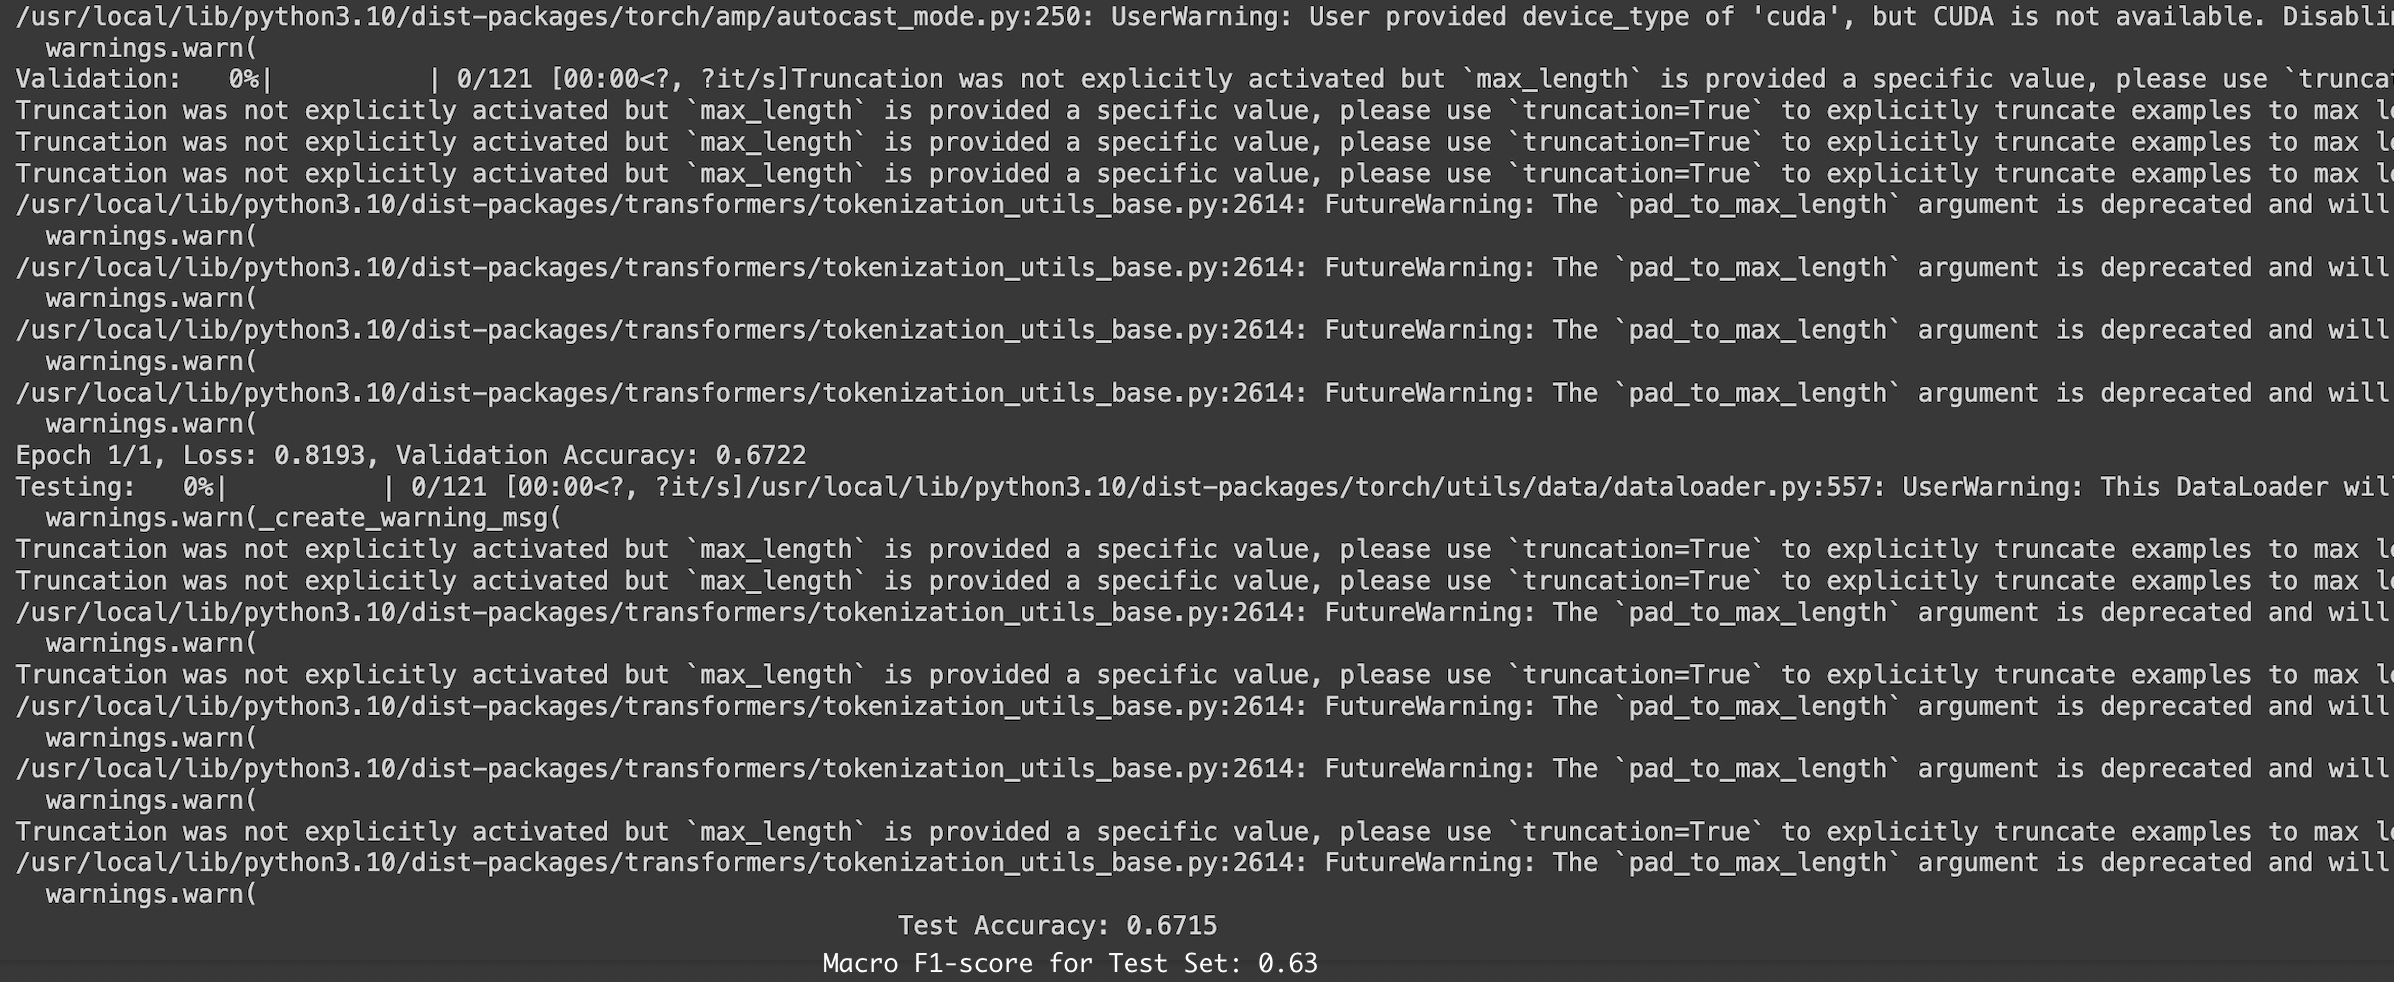

In [ ]:
!pip install transformers
!pip install --upgrade transformers

import nltk
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import gdown
import gensim

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from torch.cuda.amp import GradScaler, autocast
# Download and load the dataset
train_url = "https://drive.google.com/uc?export=download&id=1Pa-6DXYm_pfIte5KKAcKd-aECWzq5cPy"
valid_url = "https://drive.google.com/uc?export=download&id=1BDhkyqt9JmSLFpWKMFe7w7HAwTpfQfSf"
test_url = "https://drive.google.com/uc?export=download&id=1u4wx-OiwoKSXn8vSSGPGEpCDkiqKwDWd"

gdown.download(train_url, "NLP_ass_train.tsv", quiet=False)
gdown.download(valid_url, "NLP_ass_valid.tsv", quiet=False)
gdown.download(test_url, "NLP_ass_test.tsv", quiet=False)

# Load the data
train_data = pd.read_csv("NLP_ass_train.tsv", sep='\t', header=None)
valid_data = pd.read_csv("NLP_ass_valid.tsv", sep='\t', header=None)
test_data = pd.read_csv("NLP_ass_test.tsv", sep='\t', header=None)

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

train_data[0] = train_data[0].apply(lambda x: preprocess_text(x))
valid_data[0] = valid_data[0].apply(lambda x: preprocess_text(x))
test_data[0] = test_data[0].apply(lambda x: preprocess_text(x))

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[1])
valid_labels = label_encoder.transform(valid_data[1])
test_labels = label_encoder.transform(test_data[1])

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Downloading...
From: https://drive.google.com/uc?export=download&id=1Pa-6DXYm_pfIte5KKAcKd-aECWzq5cPy
To: /content/NLP_ass_train.tsv
100%|██████████| 2.11M/2.11M [00:00<00:00, 43.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1BDhkyqt9JmSLFpWKMFe7w7HAwTpfQfSf
To: /content/NLP_ass_valid.tsv
100%|██████████| 263k/263k [00:00<00:00, 89.0MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1u4wx-OiwoKSXn8vSSGPGEpCDkiqKwDWd
To: /content/NLP_ass_test.tsv
100%|██████████| 261k/261k [00:00<00:00, 86.0MB/s]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:


# Custom Dataset class for BERT tokenization
class CustomBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
         # Initialize the dataset with texts, labels, tokenizer, and maximum sequence length

        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
         # Return the total number of samples in the dataset
        return len(self.texts)

    def __getitem__(self, idx):
        # Get a single sample from the dataset and perform BERT tokenization

        text = ' '.join(self.texts[idx])  # Convert token list back to string

        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create DataLoader instances for train, validation, and test sets
train_dataset = CustomBERTDataset(train_data[0], train_labels, tokenizer)
valid_dataset = CustomBERTDataset(valid_data[0], valid_labels, tokenizer)
test_dataset = CustomBERTDataset(test_data[0], test_labels, tokenizer)

# Set batch size and create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize the BERT model for sequence classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
model.to(device)

# Alternate method tried keeping a time limit of 90 minutes, but very poor accuracy

# accumulation_steps = 4  # Define accumulation_steps here
# # Calculate maximum number of iterations to run in 20 minutes
# max_iterations = int((90 * 60) / (len(train_loader) * accumulation_steps))

# # Training loop
# epochs = 4
# patience = 2
# best_valid_accuracy = 0
# counter = 0
# scaler = GradScaler()
# import torch.optim as optim
# import torch.nn as nn

# # Define the loss function and optimizer
# loss_function = nn.CrossEntropyLoss()  # For multi-class classification tasks
# optimizer = optim.AdamW(model.parameters(), lr=2e-5)  # You can adjust the learning rate as needed

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     start_time = time.time()  # Record the start time for the epoch
#     for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)):
#         if batch_idx >= max_iterations:
#             break  # Stop training if maximum iterations reached
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         with autocast():
#             outputs = model(input_ids, attention_mask=attention_mask)
#             logits = outputs.logits
#             loss = loss_function(logits, labels)

#         scaler.scale(loss).backward()
#         if (batch_idx + 1) % accumulation_steps == 0:
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad()
#         total_loss += loss.item()

#     # Calculate elapsed time for the epoch
#     elapsed_time = time.time() - start_time
#     average_train_loss = total_loss / len(train_loader)

#     # Validation loop (perform validation only once every epoch)
#     model.eval()
#     valid_predictions, valid_labels = [], []
#     with torch.no_grad():
#         for batch in tqdm(valid_loader, desc='Validation', leave=False):
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)
#             outputs = model(input_ids, attention_mask=attention_mask)
#             logits = outputs.logits
#             predictions = torch.argmax(logits, dim=1)
#             valid_predictions.extend(predictions.cpu().numpy())
#             valid_labels.extend(labels.cpu().numpy())
#     valid_accuracy = accuracy_score(valid_labels, valid_predictions)

#     print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_train_loss:.4f}, '
#           f'Validation Accuracy: {valid_accuracy:.4f}, Elapsed Time: {elapsed_time:.2f} seconds')

#     # Early stopping
#     if valid_accuracy > best_valid_accuracy:
#         best_valid_accuracy = valid_accuracy
#         counter = 0
#         torch.save(model.state_dict(), 'best_model.pth')
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping: No improvement in validation accuracy for {} epochs.".format(patience))
#             break

# # Load the best model weights
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()




# Define optimizer, scheduler, and loss function


# Training loop
epochs = 1
patience = 2
best_valid_accuracy = 0
counter = 0
accumulation_steps = 4  # Accumulate gradients over 4 steps
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)
loss_function = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

for epoch in range(epochs):
    #Training phrase
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_function(logits, labels)
        # Backpropagation with gradient accumulation
        scaler.scale(loss).backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        total_loss += loss.item()
    average_train_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    valid_predictions, valid_labels = [], []
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc='Validation', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            valid_predictions.extend(predictions.cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())
    valid_accuracy = accuracy_score(valid_labels, valid_predictions)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_train_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

    # Early stopping
    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping: No improvement in validation accuracy for {} epochs.".format(patience))
            break

# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Test set performance
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

from sklearn.metrics import f1_score

# Convert predictions to numeric format using label encoder
# test_predictions_numeric = label_encoder.transform(test_predictions)

# Calculate macro F1-score
# macro_f1 = f1_score(test_labels, test_predictions, average='macro')
# print(f'Macro F1-score for Test Set: {macro_f1:.2f}')

# test_accuracy = accuracy_score(test_labels, test_predictions)
# print(f'Test Accuracy: {test_accuracy:.4f}')
test_macro_f1 = f1_score(test_labels, test_predictions, average='macro')  # Calculate macro F1 score

# print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Macro F1 Score: {test_macro_f1:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, o

Epoch 1/1, Loss: 0.8193, Validation Accuracy: 0.6722


Testing:   0%|          | 0/121 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `trunc

Test Accuracy: 0.6715


In [ ]:
def calculate_intersection(test_set, train_set, valid_set):
    test_sentences = set(tuple(s) for s in test_set)
    train_sentences = set(tuple(s) for s in  train_set)
    valid_sentences = set(valid_set)

    intersection_train = len(test_sentences.intersection(train_sentences))
    intersection_valid = len(test_sentences.intersection(valid_sentences))

    return intersection_train, intersection_valid

# Assuming train_data[0] contains the preprocessed sentences of the training set
# Assuming valid_data[0] contains the preprocessed sentences of the validation set
# Assuming test_data[0] contains the preprocessed sentences of the test set

intersection_train, intersection_valid = calculate_intersection(test_data[0], train_data[0], valid_data[0])

print(f"Number of common sentences between test set and train set: {intersection_train}")
print(f"Number of common sentences between test set and validation set: {intersection_valid}")